In [1]:
%load_ext lab_black

# Spectral Kernel Approximations

In [2]:
import gpjax
import gpjax.core as gpx
import gpviz as gpv
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.experimental import optimizers
import matplotlib.pyplot as plt

key = jr.PRNGKey(123)
plt.style.use(gpv.__stylesheet__)

In [3]:
def draw_gp_sample(key, N, n_train, kernel, params, noise=0.1):
    x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
    mean = jnp.zeros(N)
    cov = gpjax.kernels.gram(kernel, x, params) + gpjax.utils.I(N) * 1e-6
    y = jr.multivariate_normal(key, mean=mean, cov=cov)

    train_idx = jr.choice(
        key=key, a=jnp.arange(N), shape=(n_train,), replace=False
    ).sort()
    xtr = x[train_idx]
    ytr = y[train_idx]
    ytr += jr.normal(key, shape=ytr.shape) * noise
    return xtr, x, ytr.reshape(-1, 1), y.reshape(-1, 1)

In [4]:
N = 2000
n_train = 1000
noise = 0.1
M = 100
x, xte, y, yte = draw_gp_sample(
    key,
    N,
    n_train,
    gpx.RBF(),
    {"lengthscale": jnp.array(0.4), "variance": jnp.array(0.5)},
    noise,
)

In [5]:
training = gpx.Dataset(X=x, y=y)

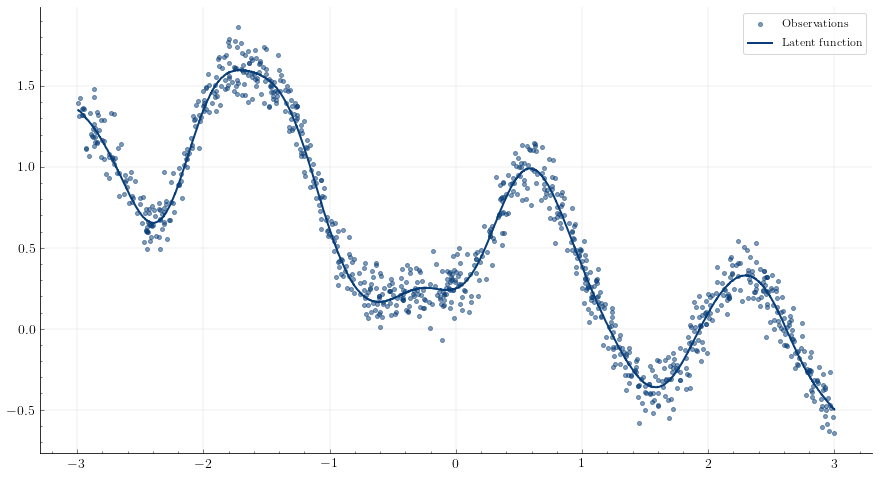

In [6]:
plt.plot(x, y, "o", label="Observations", alpha=0.5)
plt.plot(xte, yte, label="Latent function")
plt.legend(loc="best")

In [7]:
from gpjax.kernels.spectral import to_spectral

kernel = to_spectral(gpx.RBF(), M)
print(kernel)

Spectral RBF:
	 Number of basis functions: 100
	 Stationary: True 
	 ARD structure: False


In [8]:
prior = gpx.Prior(kernel=kernel)

In [9]:
posterior = prior * gpx.Gaussian()

In [10]:
print(posterior)

Sparse Spectral Posterior
--------------------------------------------------------------------------------
- Zero mean function
	 Output dimension: 1
- Spectral RBF:
	 Number of basis functions: 100
	 Stationary: True 
	 ARD structure: False
- Gaussian likelihood function


In [11]:
params = gpx.initialise(key, posterior)
params, sparams = gpx.as_constant(params, ["basis_fns"])
constrain, unconstrain = gpx.build_all_transforms(params.keys(), gpx.get_defaults())

In [12]:
params = unconstrain(params)

In [13]:
mll = jax.jit(gpx.marginal_ll(posterior, transform=constrain, negative=True))

In [14]:
mll(params, training, sparams)

DeviceArray(76812.51854211, dtype=float64)

In [15]:
opt_init, opt_update, get_params = optimizers.adam(step_size=0.05)
opt_state = opt_init(params)


def step(i, opt_state):
    p = get_params(opt_state)
    v, g = jax.value_and_grad(mll)(p, training, sparams)
    return opt_update(i, g, opt_state), v


nits = 300
mlls = []

for i in range(nits):
    opt_state, mll_estimate = step(i, opt_state)
    mlls.append(-mll_estimate)

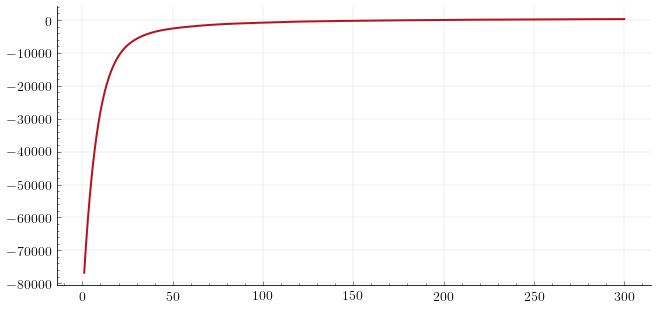

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(1, nits + 1), mlls)

In [17]:
final_params = constrain(get_params(opt_state))

In [18]:
posterior_rv = gpx.random_variable(
    posterior, final_params, training, static_params=sparams
)(xte)

In [22]:
final_params["basis_fns"] = sparams["basis_fns"]

In [20]:
mu = posterior_rv.mean()
sigma = jnp.sqrt(jnp.diag(posterior_rv.covariance()))

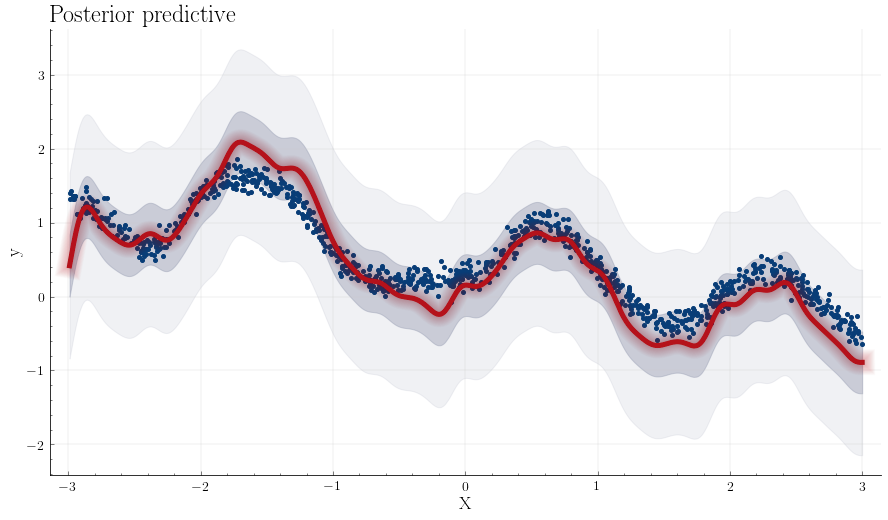

In [23]:
gpv.plot(
    key,
    posterior,
    final_params,
    training,
    xte,
    std_devs=[1, 3],
    title="Posterior predictive",
)

## System information

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -a "Thomas Pinder"

gpviz 0.0.4
gpjax 0.3.8
jax   0.2.10
Thomas Pinder 
last updated: Wed May 12 2021 

CPython 3.6.9
IPython 7.16.1
watermark 2.0.2
